In [20]:
# to enable autocomplete
%config Completer.use_jedi = False

**Reminder: TODO every time you want to  commit changes**

Go to `Edit > Clear all outputs` to clear all Notebook outputs before committing changes to the repository.

# Import necessary libraries

In [2]:
import numpy as np
import pandas as pd

In [3]:
import re
import math
import json
import datetime

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [5]:
%matplotlib inline

plt.style.use('seaborn')

mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['figure.figsize'] = [9.66, 6]
mpl.rcParams['figure.titlesize'] = 24
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 2
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

# Listings

EDA for the `listings` data.

## Loading the data

In [5]:
# Alternatively, if you are not running the Notebook in Google Colab

# from google.colab import drive 
# drive.mount('/content/drive/')
# listings = pd.read_csv('drive/MyDrive/com-480-cam/data/vaud/listings-detailed.csv')

geneva = pd.read_csv('../data/geneva/listings-detailed.csv')
geneva['city'] = 'Geneva'

vaud = pd.read_csv('../data/vaud/listings-detailed.csv')
vaud['city'] = 'Vaud'

zurich = pd.read_csv('../data/zurich/listings-detailed.csv')
zurich['city'] = 'Zurich'

listings = pd.concat([geneva, vaud, zurich])

print(f'Concatenated pd.DataFrame of shape: {listings.shape}')

Concatenated pd.DataFrame of shape: (8222, 75)


### Some routine formatting

In [6]:
# Convert dates and datetimes to pandas.DateTime
def format_dates(df: pd.DataFrame, feature: str, format: str = '%Y-%m-%d'):
    df[feature] = pd.to_datetime(df[feature], format=format)
    
# Format price by removing commas and dollar sign
def format_price(price: str):
    return float(price[1:].replace(',', ''))

# Classify property type
def find_type(property_type: str):
    
    if 'entire' in property_type.lower():
        return 'place'
    
    if 'room' in property_type.lower():
        return 'room'
    
    return 'other'

# Time since date
def days_since(d: pd.Timestamp) -> float:

    today = datetime.datetime.now()
    d = d.to_pydatetime()

    return (today - d).days

In [7]:
dated_features = ['last_scraped', 'host_since', 'calendar_last_scraped', 
                  'first_review', 'last_review']

timestamped_features = ['scrape_id']

for feature in dated_features:
    format_dates(listings, feature)
    
for feature in timestamped_features:
    format_dates(listings, feature, format='%Y%m%d%H%M%S')
    
listings['price'] = listings.price.apply(format_price)
listings['amenities_count'] = listings.amenities.apply(lambda a: len(a))
listings['type'] = listings.property_type.apply(find_type)
listings['days_host'] = listings.host_since.apply(days_since)
listings['days_host'] = listings.days_host.apply(lambda d: 0 if math.isnan(d) else int(d))

## Visualizations

### Where are the listings situated?

In [8]:
import geopandas as gpd

In [9]:
nei_geneva = gpd.read_file('../data/geneva/neighbourhoods.geojson')
nei_geneva['city'] = 'Geneva'

nei_vaud = gpd.read_file('../data/vaud/neighbourhoods.geojson')
nei_vaud['city'] = 'Vaud'

nei_zurich = gpd.read_file('../data/zurich/neighbourhoods.geojson')
nei_zurich['city'] = 'Zurich'

def join_listings(gdf: gpd.GeoDataFrame, df: pd.DataFrame, city: str) -> gpd.GeoDataFrame:
    # Extract listing number per neighbourhood
    nei = pd.DataFrame(df[df['city'] == city].neighbourhood_cleansed.value_counts())
    nei['listings'] = nei['neighbourhood_cleansed']
    nei.pop('neighbourhood_cleansed')

    # Join GEOJSON with listings
    gdf = gdf.set_index('neighbourhood').join(nei, on='neighbourhood')
    gdf.reset_index(inplace=True)
    
    return gdf

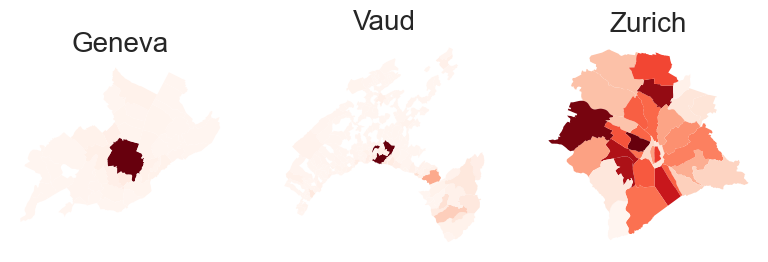

In [10]:
fig, ax = plt.subplots(1, 3)

for i, nnn in enumerate([nei_geneva, nei_vaud, nei_zurich]):
    
    city = nnn.loc[0].city
    
    join_listings(nnn, listings, city).plot(column='listings', cmap='Reds', ax=ax[i])
    ax[i].set_title(city)
    ax[i].axis('off')
    
plt.show()

### Pair plot of some variables of interest

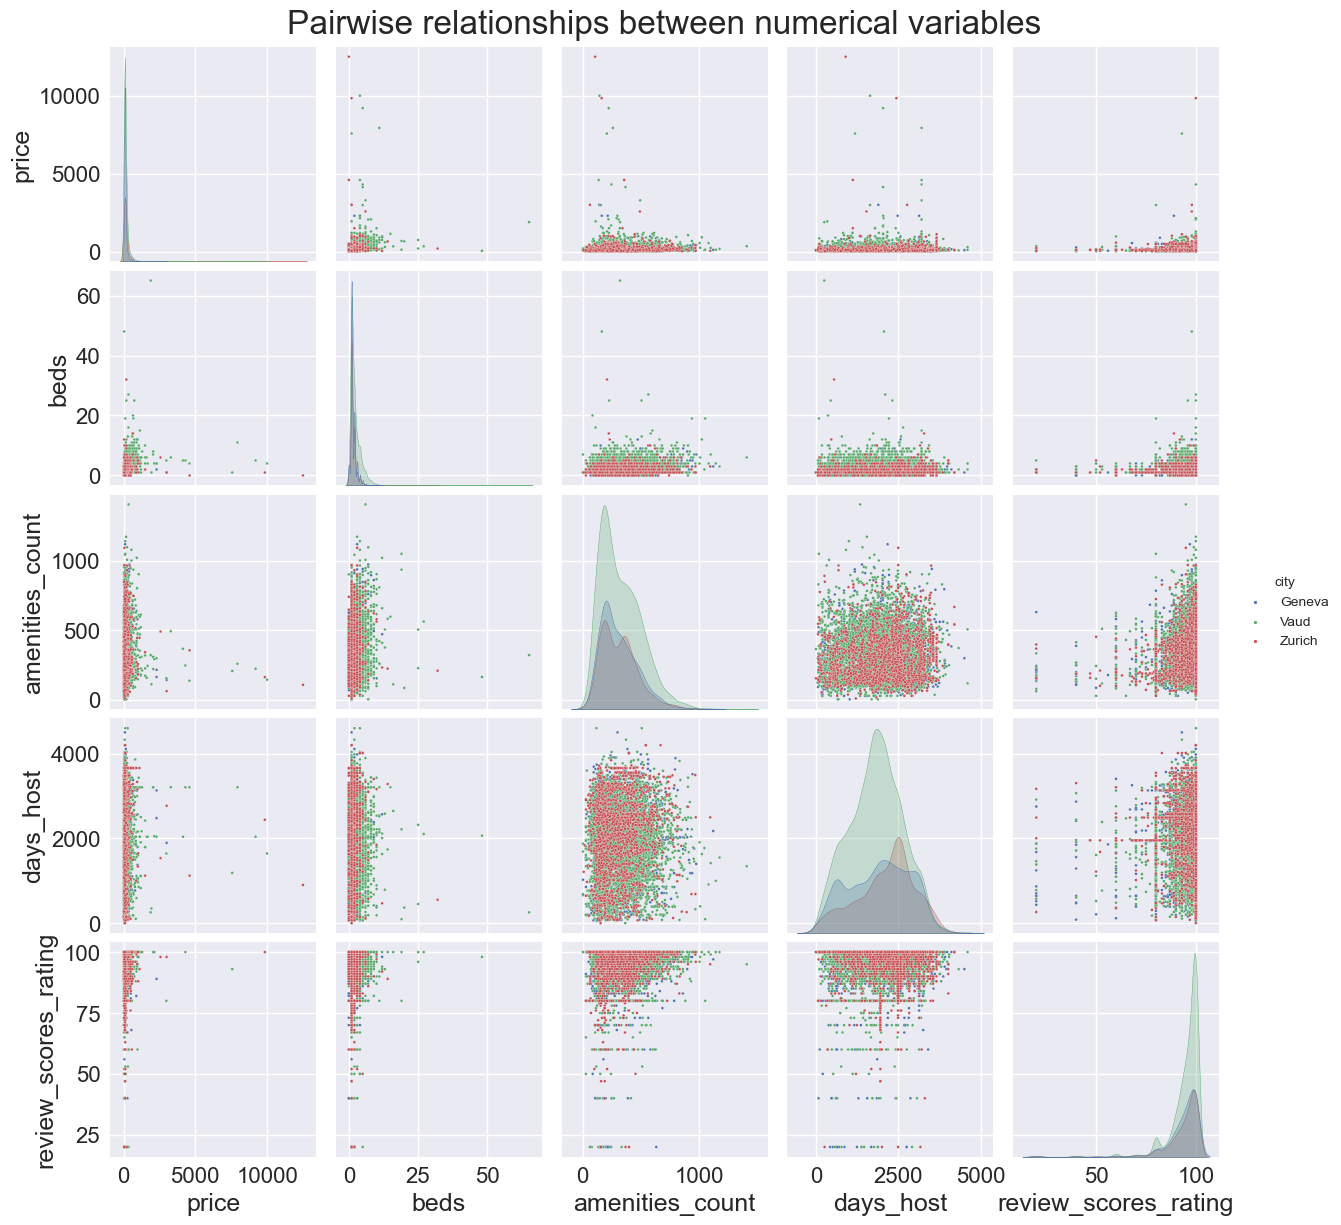

In [11]:
g = sns.pairplot(data=listings, vars=['price', 'beds', 'amenities_count', 'days_host', 'review_scores_rating'], hue="city")

g.fig.subplots_adjust(top=0.95)
g.fig.suptitle('Pairwise relationships between numerical variables')

plt.show()

### What's the most common property type?

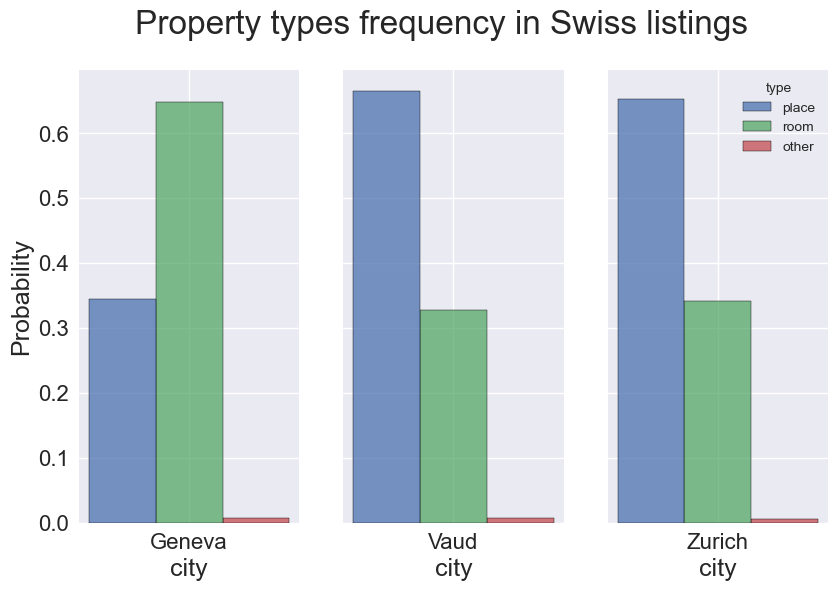

In [12]:
fig, ax = plt.subplots(1, 3, sharey=True)

sns.histplot(data=listings[listings['city'] == 'Geneva'], x="city", hue="type", multiple="dodge", stat="probability", ax=ax[0])
sns.histplot(data=listings[listings['city'] == 'Vaud'], x="city", hue="type", multiple="dodge", stat="probability", ax=ax[1])
sns.histplot(data=listings[listings['city'] == 'Zurich'], x="city", hue="type", multiple="dodge", stat="probability", ax=ax[2])

ax[0].get_legend().remove()
ax[1].get_legend().remove()

fig.suptitle('Property types frequency in Swiss listings')

plt.show()

### How does price distribution vary between entire places and private rooms?

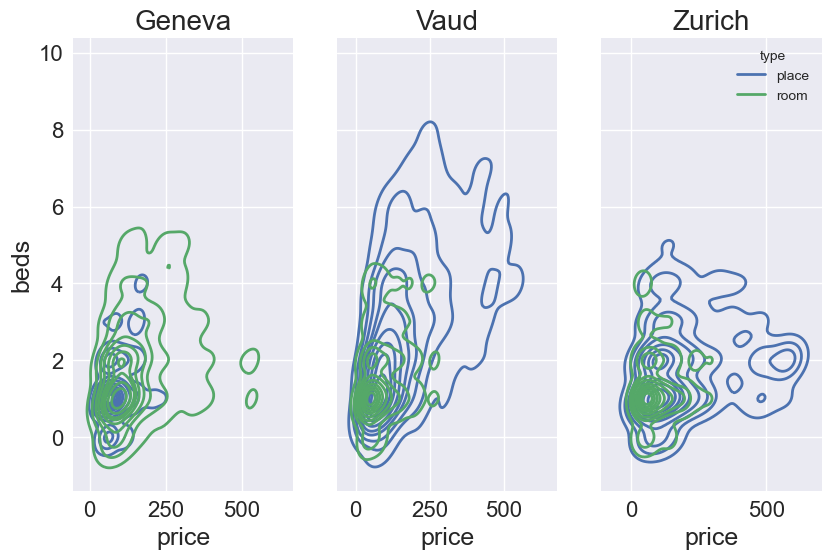

In [13]:
fig, ax = plt.subplots(1, 3, sharey=True)

sns.kdeplot(data=listings[(listings['city'] == 'Geneva') & (listings.price < 600) & (listings.beds < 10) & (listings.type.isin(['place', 'room']))],
            x="price", y="beds", hue="type", fill=False, common_norm=False, ax=ax[0])
ax[0].set_title('Geneva')

sns.kdeplot(data=listings[(listings['city'] == 'Vaud') & (listings.price < 600) & (listings.beds < 10) & (listings.type.isin(['place', 'room']))],
            x="price", y="beds", hue="type", fill=False, common_norm=False, ax=ax[1])
ax[1].set_title('Vaud')

sns.kdeplot(data=listings[(listings['city'] == 'Zurich') & (listings.price < 600) & (listings.beds < 10) & (listings.type.isin(['place', 'room']))],
            x="price", y="beds", hue="type", fill=False, common_norm=False, ax=ax[2])
ax[2].set_title('Zurich')

ax[0].get_legend().remove()
ax[1].get_legend().remove()

plt.show()

### What do the distributions of the different review categories look like?

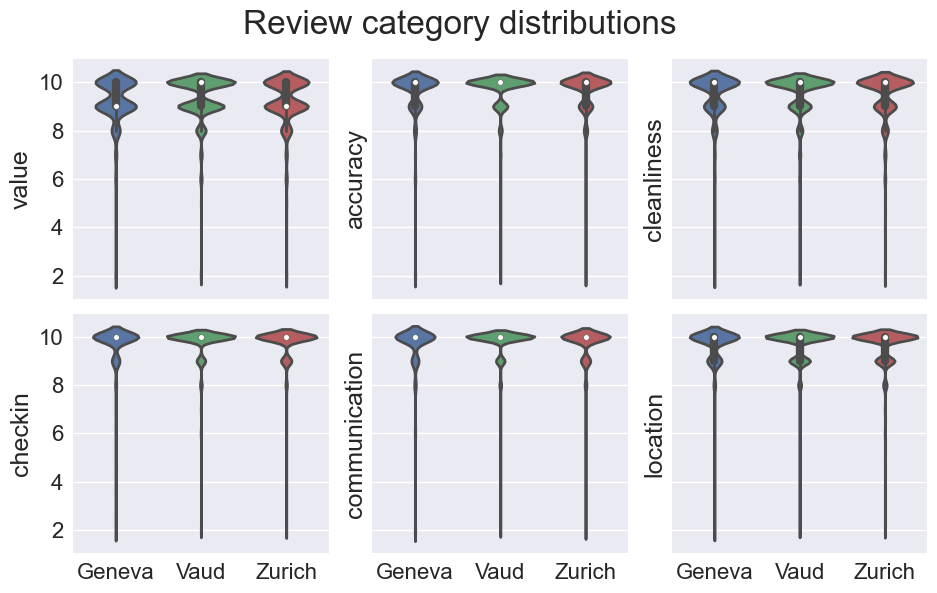

In [14]:
f, a = plt.subplots(2, 3, sharey=True, sharex=True)

reviews = ['review_scores_value', 'review_scores_accuracy', 'review_scores_cleanliness', 
           'review_scores_checkin', 'review_scores_communication', 'review_scores_location']
    
sns.violinplot(data=listings, y='review_scores_value',         x='city', ax=a[0, 0])
sns.violinplot(data=listings, y='review_scores_accuracy',      x='city', ax=a[0, 1])
sns.violinplot(data=listings, y='review_scores_cleanliness',   x='city', ax=a[0, 2])
sns.violinplot(data=listings, y='review_scores_checkin',       x='city', ax=a[1, 0])
sns.violinplot(data=listings, y='review_scores_communication', x='city', ax=a[1, 1])
sns.violinplot(data=listings, y='review_scores_location',      x='city', ax=a[1, 2])

a[0, 0].set_ylabel('value')        , a[0, 0].set_xlabel('') #, a[0, 0].set_ylim(6, 11)
a[0, 1].set_ylabel('accuracy')     , a[0, 1].set_xlabel('') #, a[0, 1].set_ylim(6, 11)   
a[0, 2].set_ylabel('cleanliness')  , a[0, 2].set_xlabel('') #, a[0, 2].set_ylim(6, 11)      
a[1, 0].set_ylabel('checkin')      , a[1, 0].set_xlabel('') #, a[1, 0].set_ylim(6, 11)
a[1, 1].set_ylabel('communication'), a[1, 1].set_xlabel('') #, a[1, 1].set_ylim(6, 11)
a[1, 2].set_ylabel('location')     , a[1, 2].set_xlabel('') #, a[1, 2].set_ylim(6, 11)

f.suptitle('Review category distributions')

plt.tight_layout()
plt.show()

### WordCloud of listing description per city

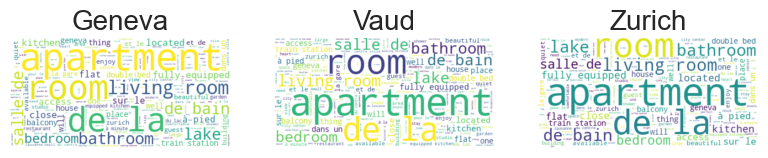

In [15]:
from wordcloud import WordCloud

def clean_text(descriptions: pd.Series) -> str:
    
    descriptions = ' '.join(listings.description.apply(lambda d: str(d)))
    descriptions = descriptions.lower()
    descriptions = re.sub('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});', '', descriptions)
    descriptions = re.sub(r'[^\w\s]', '', descriptions)
    
    return descriptions

fig, ax = plt.subplots(1, 3)

for i, city in enumerate(['Geneva', 'Vaud', 'Zurich']):
    
    text = clean_text(listings[listings['city'] == city].description)
    wc = WordCloud(background_color='white').generate(text)
    
    ax[i].imshow(wc, interpolation='bilinear')
    ax[i].set_title(city)
    ax[i].axis('off')

plt.show()

### Parse the amenities into a plottable format

In [16]:
import ast

max_amenities_index = listings.amenities.apply(lambda a: len(a)).argmax()

all_amenities = listings.amenities.iloc[max_amenities_index]
all_amenities = ast.literal_eval(all_amenities)

This takes quite a while

In [17]:
for amenity in all_amenities:
    
    listings[amenity] = listings.amenities.apply(lambda ams: amenity in ast.literal_eval(ams))

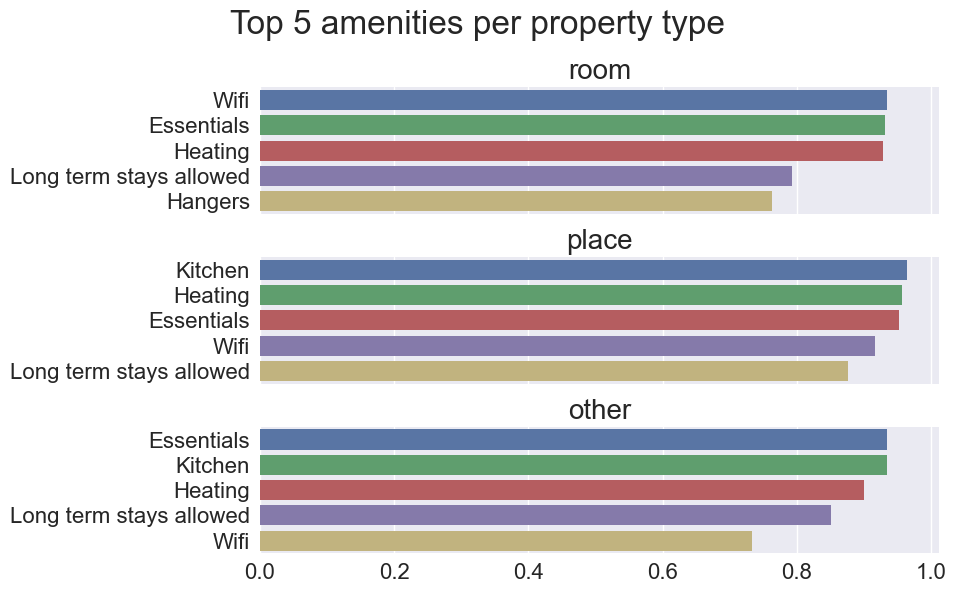

In [18]:
def top_amenities(df: pd.DataFrame) -> pd.DataFrame:

    amenities = pd.DataFrame({ amenity: df[amenity].value_counts() for amenity in df[all_amenities].columns }).T
    amenities['amenity'] = amenities.index
    amenities['probability'] = amenities[True]
    amenities['probability'] = amenities.probability.apply(lambda p: p / len(df))
    amenities.pop(False)
    amenities.pop(True)

    amenities.sort_values(by='probability', ascending=False, inplace=True)
    
    return amenities

fig, ax = plt.subplots(3, 1, sharex=True)

for i, t in enumerate(['room', 'place', 'other']):

    sns.barplot(data=top_amenities(listings[listings['type'] == t]).iloc[:5], x='probability', y='amenity', ax=ax[i])
    
    ax[i].set_title(t)
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    
fig.suptitle('Top 5 amenities per property type')

plt.tight_layout()
plt.show()

# Reviews

In [6]:
reviews = pd.read_csv('../data/vaud/reviews.csv')

In [8]:
reviews['date'] = pd.to_datetime(reviews['date'], format='%Y-%m-%d')

In [10]:
reviews.sample(10)

,listing_id,date
62534,43710444,2020-08-09
32974,19450674,2019-12-08
13804,9347038,2018-08-24
15928,11199639,2019-07-10
49576,30279512,2020-03-03
28270,16869495,2019-08-19
42254,24400182,2020-11-19
4107,2436952,2016-07-29
43761,25713073,2019-02-23
34618,20241221,2020-02-26


In [12]:
def find_top_reviews(n=10, data=reviews):
    """return list of n ids containing the most amount of reviews"""
    return data.listing_id.value_counts()[0:n].index.tolist()

In [13]:
def plot_timeperiod_reviews(start_date="2018-01", end_date="2021-01", n=1 , data=reviews):
    """plot the n average count reviews over the timeperiod"""
    data = data.set_index('date')
    data_to_plot = data[data['listing_id'].isin(find_top_reviews(n))].groupby(pd.Grouper(freq='M')).count()
    data_to_plot = data_to_plot.fillna(0)
    
    
    title_ = "Number of Reviews for the top %s Listings" %n
    data_to_plot[start_date:end_date].plot(title=title_, ylabel="number of reviews")

### How does the general trend of Reviews compare over a period of time?

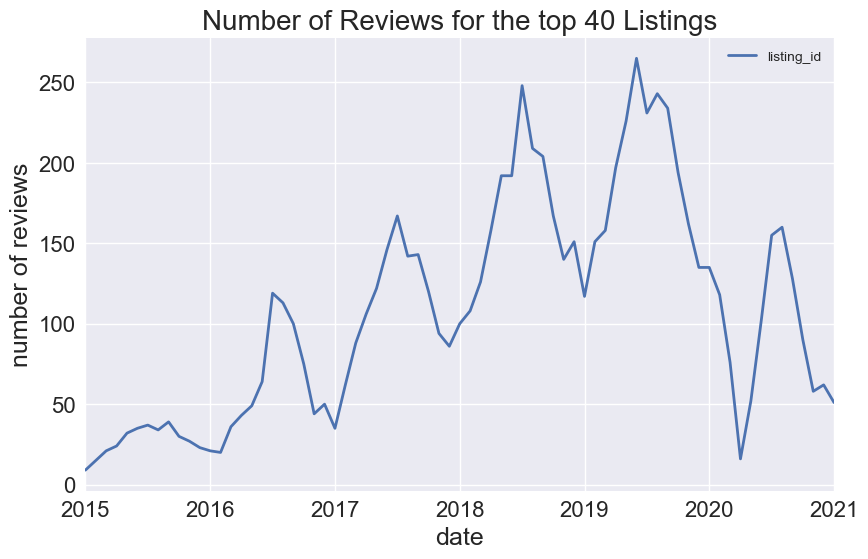

In [15]:
plot_timeperiod_reviews(start_date="2015-01", end_date='2021-01', n=40)

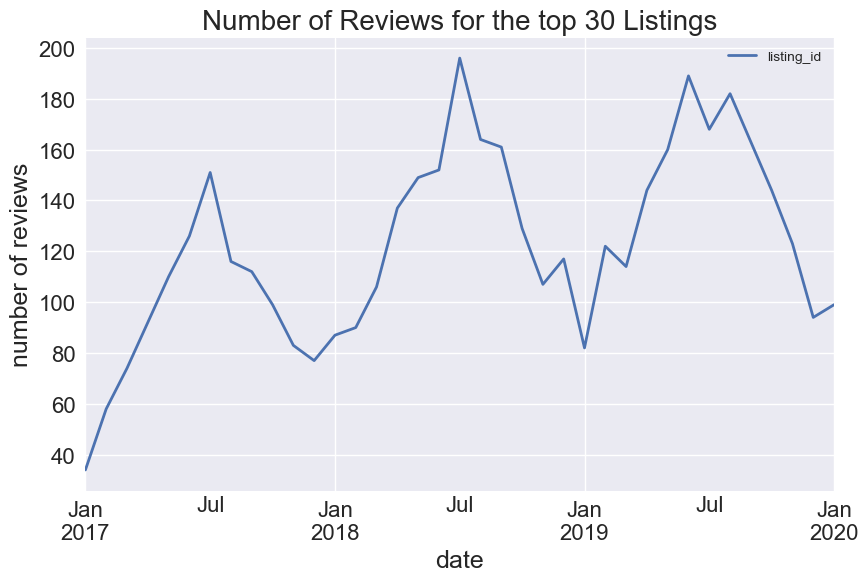

In [14]:
plot_timeperiod_reviews(start_date="2017-01", end_date='2020-01', n=30)

### Within the top 5 most reviewed listings, how do they temporally compare ?

In [16]:
from scipy.signal import savgol_filter

In [17]:
def plot_n_individual_reviews(start_date="2018-01", end_date="2021-01", n=2 , data=reviews, smoothed=True):
    """plots the top n individual reviews between the given time period"""
    
    data= reviews.set_index('date')
    data['count'] = 1 #needed to count
    data_to_plot = data[data['listing_id'].isin(find_top_reviews(n))].groupby(['listing_id', pd.Grouper(freq='M')]).count()

    pivoted_data = data_to_plot.pivot_table(index='date', columns='listing_id', values='count', fill_value=0)
    title_ = "Number of Reviews of top %s Listings" %n
    
    if smoothed:
        for col in pivoted_data.columns.to_list():
            pivoted_data[col] = savgol_filter(pivoted_data[col],11,3)

        pivoted_data[pivoted_data < 0]=0
    
    pivoted_data.plot(title=title_, ylabel="number of reviews")

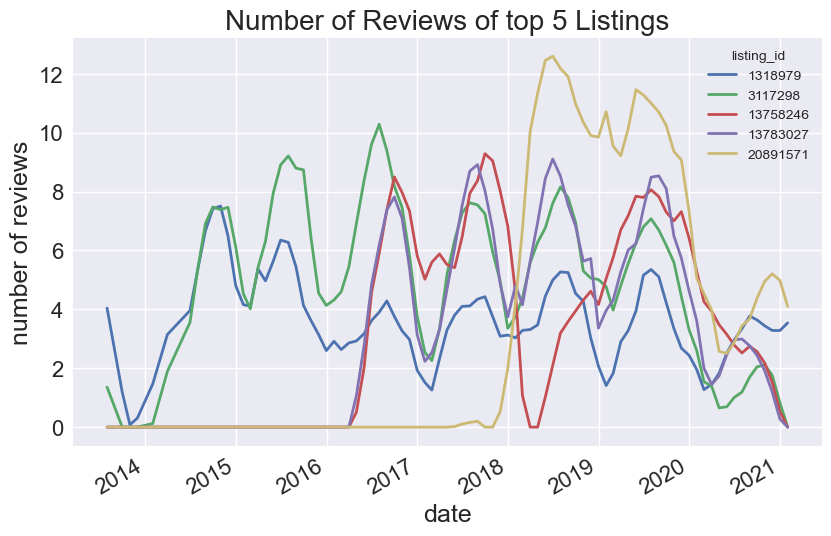

In [18]:
plot_n_individual_reviews(n=5)

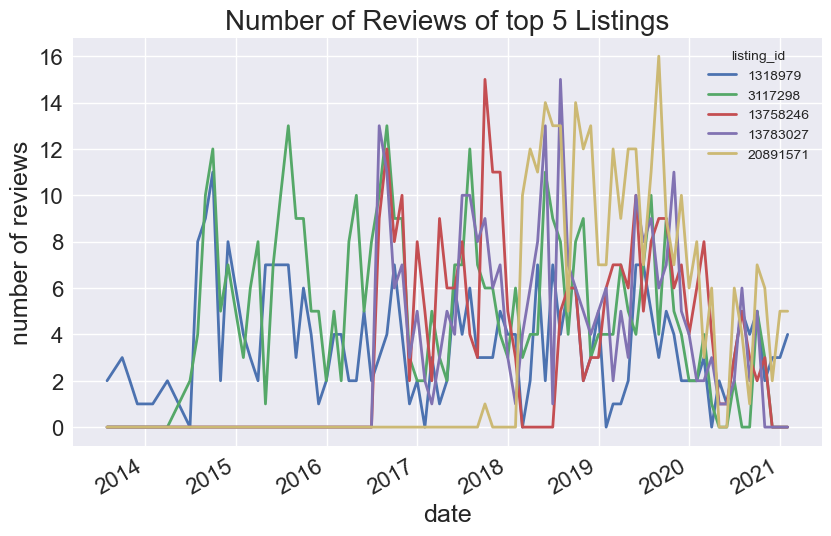

In [19]:
plot_n_individual_reviews(n=5, smoothed=False)

# Calendar